In [1]:
import keras
import numpy as np
import os
import pandas as pd
import sys
import tempfile
import tensorflow as tf
import zipfile

model_name = 'myModel3'
data_dir = os.path.join('..', 'data')
models_dir = os.path.join('..', 'models')

nvflare_app_dir = os.path.join('..', 'nvflare-sverepec_24-sim')
app_server_dir = os.path.join(nvflare_app_dir, 'workspace', 'simulate_job', 'app_server')

sys.path.append(nvflare_app_dir)
from app.custom.tf2_net import Net

from IPython.display import JSON, HTML
from nvflare.fuel.utils import fobs
from nvflare.app_common.abstract.model import ModelLearnable, make_model_learnable
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

summary_line_length = 128

## extract zip and create symlinks

In [2]:
zip_filename = os.path.join(models_dir, '%s.zip' % model_name)

with zipfile.ZipFile(zip_filename, 'r') as zf:
    zf.extractall(models_dir)

model_dir_symlink = os.path.join('.', model_name)

if not os.path.exists(model_dir_symlink):
    os.symlink(
        os.path.join(models_dir, model_name),
        model_dir_symlink,
        target_is_directory=True
    )

exec('import %s' % model_name)
exec('model = %s.load_model()' % model_name)

In [3]:
m = model
m.summary(line_length=summary_line_length, expand_nested=True)

Model: "model"
________________________________________________________________________________________________________________________________
 Layer (type)                                            Output Shape                                       Param #             
 input_1 (InputLayer)                                    [(None, 186)]                                      0                   
                                                                                                                                
 fullyConnectedLayer1_ (Dense)                           (None, 28)                                         5236                
                                                                                                                                
 batchNormalizationLayer_ (BatchNormalization)           (None, 28)                                         112                 
                                                                                  

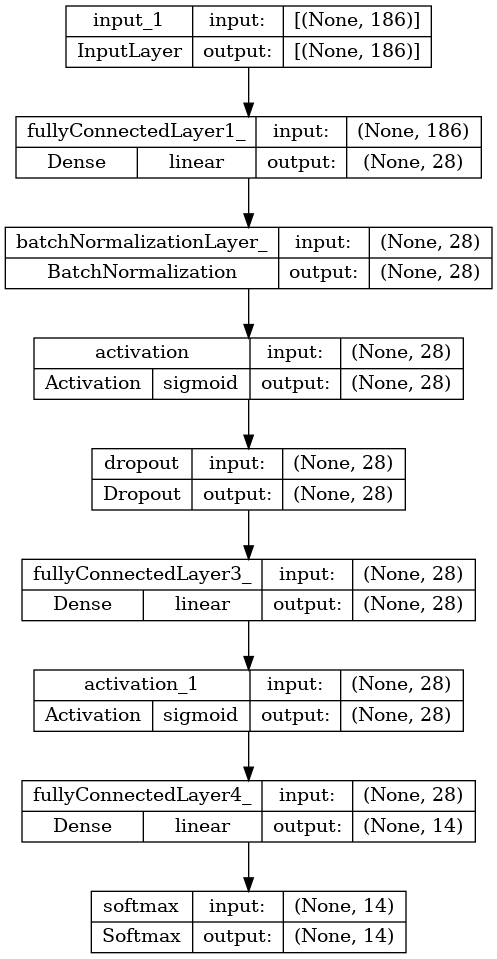

In [4]:
tf.keras.utils.plot_model(
    m,
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

## load data

In [5]:
data_filename = os.path.join(data_dir, 'Sverepec_spolu.zip')
df = pd.read_csv(data_filename)
display(df)

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10,DRUH_DR
0,0.002312,0.002194,0.002344,0.002613,0.002497,0.002717,0.002706,0.002898,0.002586,0.003052,...,0.046049,0.043585,0.043107,0.045929,0.051554,0.052172,0.054623,0.054570,0.054656,CR
1,0.002277,0.002337,0.002361,0.002488,0.002334,0.002713,0.002796,0.002779,0.002748,0.003034,...,0.042515,0.040856,0.039885,0.043333,0.047781,0.048725,0.047153,0.050167,0.052182,CR
2,0.002243,0.002479,0.002402,0.002322,0.002627,0.002943,0.002809,0.002854,0.002725,0.003096,...,0.044127,0.042798,0.042160,0.042548,0.048506,0.049747,0.050620,0.051325,0.054525,CR
3,0.001883,0.002045,0.002057,0.001970,0.002191,0.002052,0.002102,0.001991,0.001920,0.002308,...,0.035453,0.032728,0.033034,0.034035,0.037514,0.040421,0.040852,0.040839,0.042109,CR
4,0.002193,0.001915,0.002164,0.002090,0.002031,0.002108,0.002084,0.002123,0.001950,0.002291,...,0.026016,0.025324,0.024879,0.026462,0.029662,0.030414,0.031456,0.031279,0.032800,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33715,0.002469,0.002863,0.003135,0.003027,0.003056,0.003230,0.003328,0.003523,0.003396,0.003746,...,0.029615,0.028368,0.026700,0.027315,0.031556,0.033276,0.032708,0.033844,0.033287,BR
33716,0.001235,0.000966,0.000953,0.001050,0.000891,0.001143,0.000930,0.001075,0.000944,0.001074,...,0.006762,0.007508,0.006300,0.007368,0.007559,0.008111,0.009299,0.008149,0.008633,BR
33717,0.001709,0.001565,0.001225,0.001534,0.001722,0.002060,0.001738,0.001615,0.001751,0.002011,...,0.026855,0.025384,0.025439,0.025496,0.027390,0.029442,0.033317,0.032171,0.032443,BR
33718,0.001823,0.001716,0.001534,0.001772,0.001997,0.002358,0.002048,0.001988,0.001989,0.002377,...,0.029279,0.027654,0.027549,0.027910,0.030475,0.032133,0.035963,0.035193,0.035305,BR


## load label encoder

In [6]:
label_encoder = LabelEncoder()
df[df.DRUH_DR.name] = label_encoder.fit_transform(df[df.DRUH_DR.name])
label_encoder.classes_

array(['BO', 'BR', 'CR', 'DL', 'DZ', 'HB', 'JH', 'JP', 'LM', 'OS', 'SM',
       'VR', 'lieska', 'ÄŤremcha'], dtype=object)

## test model on the loaded site data

In [7]:
X = df[df.columns.drop(df.DRUH_DR.name)]

Y = df[df.DRUH_DR.name]
Y = label_encoder.inverse_transform(Y)
Y = pd.DataFrame(Y, columns=['Y'])

Y_pred = m.predict(X)
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred = label_encoder.inverse_transform(Y_pred)
Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])

display(pd.concat([Y, Y_pred], axis=1))

1054/1054 [==============================] - 3s 3ms/step


,Y,Y_pred
0,CR,CR
1,CR,OS
2,CR,CR
3,CR,CR
4,CR,CR
...,...,...
33715,BR,SM
33716,BR,SM
33717,BR,SM
33718,BR,SM


## confusion matrix

In [8]:
conf_matrix = pd.DataFrame(confusion_matrix(Y, Y_pred, labels=label_encoder.classes_))
conf_matrix.rename(columns=lambda x: label_encoder.inverse_transform([x])[0], inplace=True)
conf_matrix.rename(index=lambda x: label_encoder.inverse_transform([x])[0], inplace=True)
conf_matrix.set_index(pd.MultiIndex.from_product([['truth'], conf_matrix.index]), inplace=True)
conf_matrix.columns = pd.MultiIndex.from_product([['prediction'], conf_matrix.columns])
conf_matrix

prediction                                                      \
                       BO  BR    CR    DL DZ HB JH   JP   LM    OS     SM  VR   
truth BO                0   0     0     0  0  0  0    0    0     0     26   0   
      BR                0  40     1     3  4  0  0   20    0    56    578   9   
      CR                0   1  3222     2  0  0  0    0    0    66     14   1   
      DL                0   0    51  2763  0  0  0    1    6    70     16   8   
      DZ                0   2    10     2  9  0  0    9    0    53      3  15   
      HB                0   0     0     4  0  0  0    7    0     4     12  11   
      JH                0   0     0     0  0  0  0    0    0     0     54   0   
      JP                0   0     0     1  0  0  0  622    9     0      2   0   
      LM                0   0     0   188  0  0  0    5  347     0      0   0   
      OS                0   1    25    15  0  0  0    1    0  6054    126   6   
      SM                0  10     4     5  1  0  0    4    0   174  18157  13   
      VR                0   3    18    25  0  0  0    0    0    72    149  90   
      lieska            0   5     1    12  0  0  0    5    1     1      4   1   
      ÄŤremcha          0   0    69     1  0  0  0    0    4     0      0   0   

                                
               lieska ÄŤremcha  
truth BO            0        0  
      BR           16        0  
      CR            2        6  
      DL            1        0  
      DZ           22        0  
      HB            0        0  
      JH            0        0  
      JP            5        2  
      LM            3        2  
      OS            4        0  
      SM            0        0  
      VR            0        0  
      lieska      193        0  
      ÄŤremcha      2       78